# Capsule robot simulation

In [1]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants as constants
import scipy.integrate as integrate
import os
import pickle
import time

# Model parameters

In [2]:
part1 = False
if (not part1):
    M = 193E-3 #weight of body
    m = 74E-3 #weight of inner body
    c = 256.23 # spring stiffnes coefficient
    F = 1.25 # Coil retractor force 1.25
    R = 0.71 # Friction force
else:
    M = 21.3E-3 #weight of body
    m = 23.1E-3 #weight of inner body
    c = 360 # spring stiffnes coefficient
    F = 0.8 # Coil retractor force
    R = 0.7 # Friction force
        
w = np.sqrt(c*(M + m)/M/m) # Natural frequency
g = constants.g # gravitation

# Capsule robot equations

In [3]:
LH = 2.7                         # length of soleoid
radius_0 = 7                     # diameter of solenoid core
radius_av = 16
S = np.pi * radius_0**2          # where D is diameter of solenoid core

mju_zero = 4.0 * np.pi * 10E-7   # Размерность: Гн/м
mju_r = 290.0                    # Относительная магнитн. прониц. (Табл. величина, которая для нашего случая подбирается
                                 # так, чтобы график силы был похож на экспериментальный).
                                 # из-за того, что мы не знаем магн. прониц. сердечника
mju = mju_zero * mju_r           # permeability of the material

winding_factor = (radius_0 / radius_av)**2

#gamma = 0.0175 / 0.7854 # resistivity of cupper divided by cross-sectional area of the wire 1 mm
gamma = 0.042                    # табл. велич., которая также подбирается по адекватности для нашей модели
                                 # т.к. мы не знаем диаметр проволоки в катушке (0,042 для диаметра 0,723 мм)

alpha = np.log(mju_r)            # определяет вогнутость экспоненты
k_shape = 0.2                    # 0.5 - подстроечный коэфф., выбираемый чисто эмпирически. Отвечает за форму экспоненты
                                 # чем меньше коэфф., тем менее вогнутая экспонента


def F_fr(x, R, beta=10.0E5):
    """
    Defines friction force
    """
    return -R*2/np.pi*np.arctan(x*beta)

def F_e(t, T, tau, beta=10.0E5):
    """
    Defines electromagnteic force of coil (working or not)
    """
    return F*(1. - 2./np.pi*np.arctan((np.modf(t/T)[0] - tau)*beta))/2.

def final_force_form(t, T, tau, ksi, beta=10.0E5):
    """
    Defines electromagnteic force of coil (working or not)
    """
    def PWM_signal(): #t, T, tau
        V = (1. - 2./np.pi*np.arctan((np.modf(t/T)[0] - tau)*beta)) * 6.
        return V
    V = PWM_signal()
    
    dx = -(ksi - 2)
    F = np.sign(dx)*((V**2 * mju) / (8.0 * np.pi * gamma**2 * LH**2)) * winding_factor * alpha * np.exp(-(alpha / LH) * abs(dx)*k_shape)
    return F


def f(x, t, p):
    """
    Defines the differential equations for the capsule-bot
     Arguments:
        x :  vector of the state variables:
                  w = [x, x_dot, ksi, ksi_dot]
                  x - position of center of mass
                  ksi - position of inner body. ksi = 0 means that spring is relaxed.
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,T,tau]
    """
    x, x_dot, ksi, ksi_dot = x
    T, tau = p
    
    total_mass = M + m
    m1 = M/total_mass
    m2 = m/total_mass
    #F = final_force_form(t, T, tau, ksi)
    F = F_e(t, T, tau) # old

    body_v =  x_dot - m2*ksi_dot
    
    f = [x_dot,
         F_fr(body_v, R)/total_mass,
         ksi_dot,
         F/m1/m - F_fr(body_v, R)/M - c*ksi/m1/m]
    
    return f

"""
Tanh version of force
"""

def final_force_form(t, T, tau, ksi):
    """
    Defines electromagnteic force of coil (working or not)
    """
    def PWM_signal(): #t, T, tau
        V = (1. - 2./np.pi*np.arctan((np.modf(t/T)[0] - tau)*10.E5)) * 6.
        return V
    V = PWM_signal()
    
    dx = -(ksi - 1)
    F = np.tanh(dx)*((V**2 * mju) / (8.0 * np.pi * gamma**2 * LH**2)) * winding_factor * alpha * np.exp(-(alpha / LH) * abs(dx)*k_shape)
    return F

def f(x, t, p):
    """
    Defines the differential equations for the capsule-bot
     Arguments:
        x :  vector of the state variables:
                  w = [x, x_dot, ksi, ksi_dot]
                  x - position of center of mass
                  ksi - position of inner body
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,eps,T,tau]
    """
    x, x_dot, ksi, ksi_dot = x
    m1, m2, eps, T, tau = p
    
    body_v =  x_dot - m2*ksi_dot
    
    f = [x_dot,
         m1*m2*F_fr(body_v, eps),
         ksi_dot,
         final_force_form(t, T, tau, ksi) - m2*F_fr(body_v, eps) - ksi] # new
         #F_e(t, T, tau) - m2*F_fr(body_v, eps) - ksi] # old
    
    return f

# Force graph

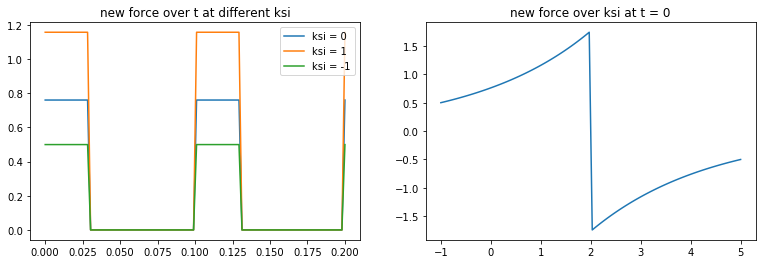

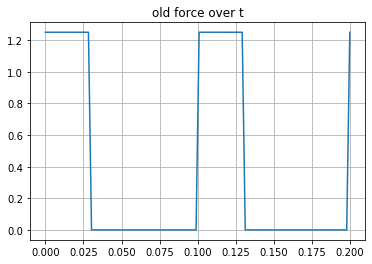

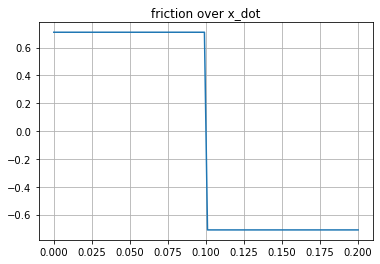

In [14]:
__tau = 0.3
__T = 100E-3 # ms

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(13)
ax1.set_title('new force over t at different ksi')
__t = np.linspace(0, 2*__T, 100)
__F_0 = [final_force_form(x, __T, __tau, 0) for x in __t]
__F_1 = [final_force_form(x, __T, __tau, 1) for x in __t]
__F_m1 = [final_force_form(x, __T, __tau, -1) for x in __t]
ax1.plot(__t, __F_0, label="ksi = 0")
ax1.plot(__t, __F_1, label="ksi = 1")
ax1.plot(__t, __F_m1, label="ksi = -1")
ax1.legend()

ax2.set_title('new force over ksi at t = 0')
__ksi = np.linspace(-1, 5, 100)
__F = [final_force_form(0, __T, __tau, x) for x in __ksi]
ax2.plot(__ksi, __F)

plt.figure()
plt.title("old force over t")
_t = np.linspace(0, 2*__T, 100)
__F = [F_e(x, __T, __tau) for x in _t]
plt.plot(_t, __F)
plt.grid(True)


plt.figure()
plt.title("friction over x_dot")
__x_dot = np.linspace(-1, 1, 100)
__F_Fr = [F_fr(x, R) for x in __x_dot]
plt.plot(_t, __F_Fr)
plt.grid(True)

# Trajectory of movement

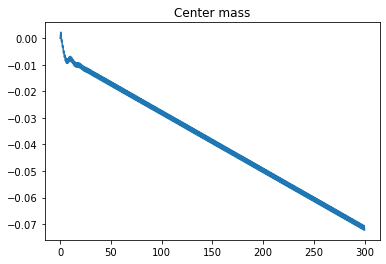

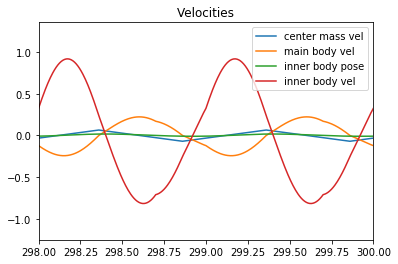

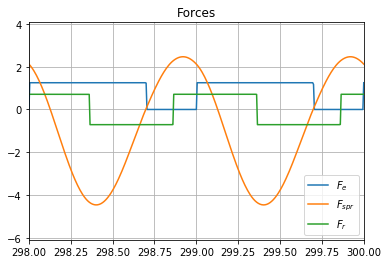

In [28]:
abserr = 1.0e-8
relerr = 1.0e-6

x0 = [0., 0., 0., 0.]
#Integration time
n_periods = 300
steps_in_period = 200

_T = 0.101139763882459 #
_tau = 0.7
_m2 = m/(M + m)
t = np.linspace(0, n_periods*_T, steps_in_period*n_periods)
p = (_T, _tau)
wsol = integrate.odeint(f, x0, t, args=(p,))

plt.figure()
plt.title("Center mass")
val = wsol[:, 0]
plt.plot(t/_T, wsol[:, 0], label='center mass pose over period')

plt.figure()
plt.title("Velocities")
body_v = wsol[:, 1]  - _m2*wsol[:, 3]
plt.plot(t/_T, wsol[:, 1], label='center mass vel')
plt.plot(t/_T, body_v, label='main body vel')
plt.plot(t/_T, wsol[:, 2], label='inner body pose')
plt.plot(t/_T, wsol[:, 3], label='inner body vel')
plt.xlim([(n_periods - 2), (n_periods)])
plt.legend()

plt.figure()
plt.title("Forces")
__F_e = F_e(t, _T, _tau)
__F_spr = -c*wsol[:, 2]
__F_fr = F_fr(body_v, R)
plt.plot(t/_T, __F_e, label='$F_e$')
plt.plot(t/_T, __F_spr, label='$F_{spr}$')
plt.plot(t/_T, __F_fr, label='$F_{r}$')
#plt.plot(t/_T, __F_e - __F_spr, label='$F_e - F_{spr}$')
plt.xlim([(n_periods - 2), (n_periods)])
plt.grid()
plt.legend()


# Av_vs vs tau

In [42]:
import scipy.constants as constants

abserr = 1.0e-8
relerr = 1.0e-6
av_v = dict()
p_space = dict()

# model parameters
tau_space = np.linspace(0.0, 0.5, 10+1)
T_space = np.array([0.066, 0.1])

n = len(tau_space)*len(T_space)

#Integration time
n_periods = 200
steps_in_period = 800

last_t = time.time()
t = time.localtime()
short_t = "yd%dh%d" % (t.tm_yday, t.tm_hour)
output = open('ignore/V_tau_%s.pkl' % (short_t), 'wb')
dt = 3.5 # 10**4 ~ 1 sec of inter
i = 0
conv = 1/n

for T in T_space:
    t = np.linspace(0, n_periods*T, steps_in_period*n_periods)
    for tau in tau_space:
        p = (T, tau)
        x0 = [0, 0, 0, 0]
        wsol = integrate.odeint(f, x0, t, args=(p,))
        av_v[p] = wsol[-1][0]/t[-1]
        
        dt =  (1 - conv)*dt + conv*(time.time() - last_t)            
        print('elapsed time = %.2f min'%(dt*(n - i)/60.))
        i = i + 1
        last_t = time.time()
pickle.dump(av_v, output)
output.close()
print('\nfinished')

elapsed time = 1.25 min
elapsed time = 1.18 min
elapsed time = 1.11 min
elapsed time = 1.05 min
elapsed time = 1.00 min
elapsed time = 0.97 min
elapsed time = 0.91 min
elapsed time = 0.86 min
elapsed time = 0.81 min
elapsed time = 0.75 min
elapsed time = 0.70 min
elapsed time = 0.63 min
elapsed time = 0.58 min
elapsed time = 0.53 min
elapsed time = 0.47 min
elapsed time = 0.41 min
elapsed time = 0.36 min
elapsed time = 0.31 min
elapsed time = 0.25 min
elapsed time = 0.19 min
elapsed time = 0.12 min
elapsed time = 0.06 min

finished


# Plot graphs and compare to experiment

In [34]:
#f = open('ignore/V_tau_yd256h18.pkl', 'rb')
#tau_space = np.linspace(0.0, 0.5, 10+1)
#T_space = np.array([0.66, 1.1])*constants.pi*2 
#av_v = pickle.load(f)

def get_dict_array_from_dict(d, param_idx):
    temp = dict()
    for key in av_v.keys():
        param = key[param_idx]
        if (param not in temp):
            temp[param] = []
        temp[param].append(d[key])
    return temp

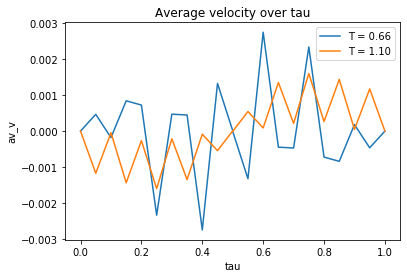

In [38]:
plt.figure()
plt.title("Average velocity over tau")
d = get_dict_array_from_dict(av_v, 0)
for param in T_space:
    name = "T = %.2f" % param
    x_vals = np.append(tau_space, tau_space + 0.5)
    y_vals = np.append(d[param], np.flip(-np.array(d[param])))
    plt.plot(x_vals, y_vals, label=name)
    plt.ylabel("av_v")
    plt.xlabel("tau")
plt.legend()

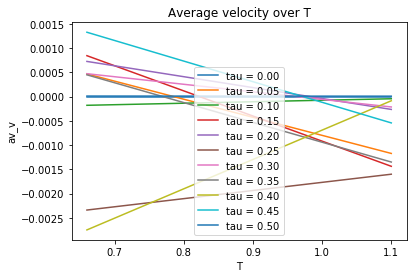

In [39]:
plt.figure()
plt.title("Average velocity over T")
d = get_dict_array_from_dict(av_v, 1)
for param in tau_space:
    name = "tau = %.2f" % param
    x_vals = T_space
    y_vals = d[param]
    plt.plot(x_vals, y_vals, label=name)
    plt.ylabel("av_v")
    plt.xlabel("T")
plt.legend()

# Experiment

df_all
     T  tau    n    x    V tau - 50    T.1   T.2   tau.1   tau.2     V.1  \
0   ms    %  NaN   cm  m/s        %     ms    ms       %       %     NaN   
1  NaN  NaN  NaN  NaN  NaN      NaN  T=100  T=60  tau=30  tau=70  T=1.10   

      V.2     V.3     V.4                    tau.3  
0     NaN     m/s     m/s                      NaN  
1  T=0.66  tau=30  tau=70  Divided by 100 of "tau"  


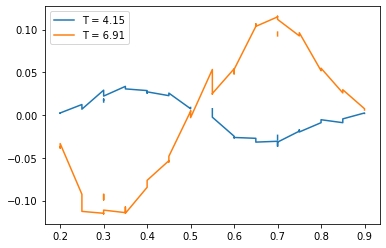

In [29]:
df_all = pd.read_csv('exp_data.csv', sep=';', dtype=str).apply(lambda x: x.str.replace(',','.'))
print('df_all')
print(df_all.head(n=2))
df_all = df_all[2:]
raw110_x = np.array(df_all['tau.3'].replace('--','NaN'), dtype=float)
raw110_y = np.array(df_all['V.1'].replace('--','NaN'), dtype=float)
raw066_x = np.array(df_all['tau.3'].replace('--','NaN'), dtype=float)
raw066_y = np.array(df_all['V.2'].replace('--','NaN'), dtype=float)

plt.plot(raw066_x, raw066_y, label="T = {:.2f}".format(0.66*constants.pi*2))
plt.plot(raw110_x, raw110_y, label="T = {:.2f}".format(1.10*constants.pi*2))
plt.legend()

# Together

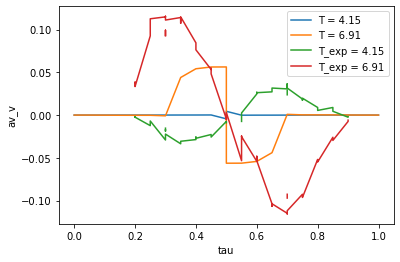

In [30]:
plt.figure()
for param in T_space:
    name = "T = %.2f" % param
    x_vals = np.append(tau_space, tau_space + 0.5)
    y_vals = np.append(d[param], np.flip(-np.array(d[param])))
    plt.plot(x_vals, y_vals, label=name)
plt.plot(raw066_x, -raw066_y, label="T_exp = {:.2f}".format(0.66*constants.pi*2))
plt.plot(raw110_x, -raw110_y, label="T_exp = {:.2f}".format(1.10*constants.pi*2))
plt.xlabel("tau")
plt.ylabel("av_v")
plt.legend()

# V vs m1

# Av_v vs T

In [ ]:
abserr = 1.0e-8
relerr = 1.0e-6
av_v = dict()
p_space = dict()

# model parameters
#T_space = np.array([60, 100])*1E-3/toSec #np.linspace(30, 135, 22)*1E-3/toSec
tau_space = np.linspace(0.0, 0.5, 11)
T_space = np.linspace(5, 24, (24-5)*2)
eps_space = [eps,] #np.linspace(0, 3, 3*4+1)
m1_space = [0.05, 0.08, 0.1]#np.linspace(0.05, 0.95, 10*2 - 1)

n = len(tau_space)*len(T_space)*len(eps_space)*len(m1_space)

#av_v[tau_space[0]] = []
#av_v[T_space[1]] = []
#p_space[tau_space[0]] = []
#p_space[T_space[1]] = []

#Integration time
n_periods = 300
steps_in_period = 100

last_t = time.time()
t = time.localtime()
short_t = "yd%dh%d" % (t.tm_yday, t.tm_hour)
output = open('output_data/V_m1_%s.pkl' % (short_t), 'wb')
dt = n_periods*steps_in_period/10**4 # 10**4 ~ 1 sec of inter
i = 0
conv = 1/n
for param in m1_space:
    for T in T_space:
        t = np.linspace(0, n_periods*T, steps_in_period*n_periods)
        for tau in tau_space:
            p = (param, 1 - param, eps, T, tau)
            x0 = [0, 0, 0, 0]
            wsol = integrate.odeint(f, x0, t, args=(p,))
            av_v[p] = wsol[-1][0]/t[-1]
            
            dt =  (1 - conv)*dt + conv*(time.time() - last_t)            
            print('elapsed time = %.2f min'%(dt*(n - i)/60.), end=';\t')
            print(p, end='\r', flush=True)
            i = i + 1
            last_t = time.time()
            #print(p)
            #print(wsol[-1][0])
pickle.dump(av_v, output)
output.close()
print('\nfinished')

elapsed time = 0.05 min;	(0.1, 0.9, 0.8749999999999999, 24.0, 0.5))00000000000003)0000000000003))3)
finished


In [ ]:
abserr = 1.0e-8
relerr = 1.0e-6
av_v = dict()
p_space = dict()

# model parameters
#T_space = np.array([60, 100])*1E-3/toSec #np.linspace(30, 135, 22)*1E-3/toSec
tau_space = [0.2]
T_space = np.linspace(0.1, 10, 10**2)

av_v[tau_space[0]] = []
#av_v[T_space[1]] = []
p_space[tau_space[0]] = []
#p_space[T_space[1]] = []

#Integration time
n_periods = 200
steps_in_period = 100
eps = eps - 0.1
for T in T_space:
    t = np.linspace(0, n_periods*T, steps_in_period*n_periods)
    for tau in tau_space:
        p = [m1, m2, eps, T, tau]
        x0 = [0, 0, 0, 0]
        wsol = integrate.odeint(f, x0, t, args=(p,))
        av_v[tau].append(wsol[-1][0]/t[-1])
        p_space[tau].append([T, tau])
        print(T, tau)
        #print(wsol[-1][0])

0.1 0.2
0.2 0.2
0.30000000000000004 0.2
0.4 0.2
0.5 0.2
0.6 0.2
0.7000000000000001 0.2
0.8 0.2
0.9 0.2
1.0 0.2
1.1 0.2
1.2000000000000002 0.2
1.3000000000000003 0.2
1.4000000000000001 0.2
1.5000000000000002 0.2
1.6 0.2
1.7000000000000002 0.2
1.8000000000000003 0.2
1.9000000000000001 0.2
2.0 0.2
2.1 0.2
2.2 0.2
2.3000000000000003 0.2
2.4000000000000004 0.2
2.5000000000000004 0.2
2.6 0.2
2.7 0.2
2.8000000000000003 0.2
2.9000000000000004 0.2
3.0000000000000004 0.2
3.1 0.2
3.2 0.2
3.3000000000000003 0.2
3.4000000000000004 0.2
3.5000000000000004 0.2
3.6 0.2
3.7 0.2
3.8000000000000003 0.2
3.9000000000000004 0.2
4.0 0.2
4.1 0.2
4.2 0.2
4.3 0.2
4.3999999999999995 0.2
4.5 0.2
4.6 0.2
4.7 0.2
4.8 0.2
4.9 0.2
5.0 0.2
5.1 0.2
5.2 0.2
5.3 0.2
5.4 0.2
5.5 0.2
5.6 0.2
5.7 0.2
5.8 0.2
5.9 0.2
6.0 0.2
6.1 0.2
6.2 0.2
6.3 0.2
6.4 0.2
6.5 0.2
6.6 0.2
6.7 0.2
6.8 0.2
6.9 0.2
7.0 0.2
7.1 0.2
7.2 0.2
7.3 0.2
7.4 0.2
7.5 0.2
7.6 0.2
7.7 0.2
7.8 0.2
7.9 0.2
8.0 0.2
8.1 0.2
8.2 0.2
8.3 0.2
8.4 0.2
8.5 0.2
8.6 

# Энергозатраты

In [ ]:
abserr = 1.0e-8
relerr = 1.0e-6
av_v = dict()
en_efficienty = dict()
p_space = dict()

def fr_work(x, t, p):
    x_dot = x[:,1]
    ksi_dot = x[:,3]
    #x, x_dot, ksi, ksi_dot = x
    m1, m2, eps, T, tau = p
    body_v =  x_dot - m2*ksi_dot
    work = .0
    def _f(_i):
        #print(_i)
        #print(body_v[_i])
        return F_fr(body_v[_i], eps)*body_v[_i];
    
    for i in range(len(t) - 1):
        work = work + _f(i)*(t[i + 1] - t[i])
    return work

# model parameters
#T_space = np.array([60, 100])*1E-3/toSec #np.linspace(30, 135, 22)*1E-3/toSec
tau_space = np.linspace(0.0, 1, 10*3+1)
T_space = np.linspace(0.5, 10, 10*5+1)
eps_space = [eps,] # np.linspace(3., 100., 3)

n = len(tau_space)*len(T_space)*len(eps_space)

#av_v[tau_space[0]] = []
#av_v[T_space[1]] = []
#p_space[tau_space[0]] = []
#p_space[T_space[1]] = []

#Integration time
n_periods = 300
steps_in_period = 300

last_t = time.time()
t = time.localtime()
short_t = "yd%dh%d" % (t.tm_yday, t.tm_hour)
output1 = open('output_data/V_work_%s.pkl' % (short_t), 'wb')
output2 = open('output_data/Work_%s.pkl' % (short_t), 'wb')
dt = n_periods*steps_in_period/10**4 # 10**4 ~ 1 sec of inter
i = 0
conv = 1/n
for param in eps_space:
    for T in T_space:
        t = np.linspace(0, n_periods*T, steps_in_period*n_periods)
        for tau in tau_space:
            p = (m1, m2, param, T, tau)
            x0 = [0, 0, 0, 0]
            wsol = integrate.odeint(f, x0, t, args=(p,))
            av_v[p] = wsol[-1][0]/t[-1]
            en_efficienty[p] = fr_work(wsol, t, p)
            dt =  (1 - conv)*dt + conv*(time.time() - last_t)            
            print('elapsed time = %.2f min'%(dt*(n - i)/60.), end=';\t')
            print(p, end='\r', flush=True)
            i = i + 1
            last_t = time.time()
            #print(p)
            #print(wsol[-1][0])
pickle.dump(av_v, output1)
pickle.dump(en_efficienty, output2)
output.close()
print('\nfinished')

elapsed time = 0.09 min;	(0.47972972972972977, 0.5202702702702703, 0.8749999999999999, 10.0, 1.0)66666666666667))66666666667)))))
finished


array([1.87536990e-09, 4.19572456e-07, 3.61041467e-09, 8.06559861e-07])

In [ ]:
eps

0.8749999999999999

<IPython.core.display.Javascript object>


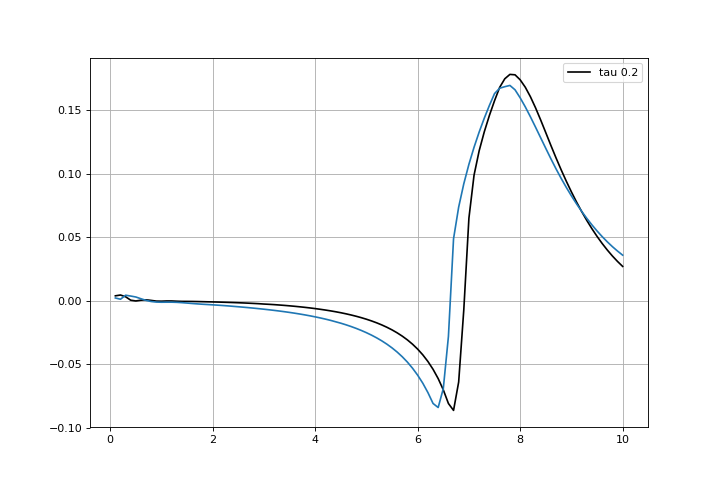

In [ ]:
#exp_x, exp_y = np.loadtxt('tau70.out')
plt.figure(figsize=(9,6))
plt.plot(T_space, np.array(av_v[tau_space[0]]), 'k', label='tau 0.2')
plt.grid()
plt.legend()


# Av vs T

In [ ]:
abserr = 1.0e-8
relerr = 1.0e-6
av_v = dict()
p_space = dict()

# model parameters
T_space = np.linspace(30, 135, 22)
tau_space = [0.23, ]np.linspace(0, 1, 10**2 + 1)
#T_space = np.array([0.1, ])

av_v[T_space[0]] = []
#av_v[T_space[1]] = []
p_space[T_space[0]] = []
#p_space[T_space[1]] = []

#Integration time
n_periods = 100
steps_in_period = 100

for T in T_space:
    t = np.linspace(0, n_periods*T, steps_in_period*n_periods)
    for tau in tau_space:
        p = [m1, m2, eps, T, tau]
        x0 = [0, 0, 0, 0]
        wsol = integrate.odeint(f, x0, t, args=(p,))
        av_v[T].append(wsol[-1][0]/t[-1])
        p_space[T].append([T, tau])
        print(T, tau)
        #print(wsol[-1][0])
        
        
plt.figure()
plt.xlim([0, 10])
plt.plot(np.array(tau_space), np.array(av_v[T_space[0]]), 'k', label='T = 60ms, calculated data')
#major_ticks = np.arange(0, 1.1, 0.1)
#minor_ticks = np.arange(0, 1.1, 0.05)
#plt.xticks(major_ticks)
#plt.xticks(minor_ticks, minor=True)
plt.grid(which='both')
plt.legend()

# Av_v vs tau

In [ ]:
abserr = 1.0e-8
relerr = 1.0e-6
av_v = dict()
p_space = dict()

# model parameters
#T_space = np.array([60, 100])*1E-3/toSec #np.linspace(30, 135, 22)*1E-3/toSec
tau_space = np.linspace(0, 1, 10**2 + 1)
T_space = np.array([7.7, ])

av_v[T_space[0]] = []
#av_v[T_space[1]] = []
p_space[T_space[0]] = []
#p_space[T_space[1]] = []

#Integration time
n_periods = 100
steps_in_period = 100

for T in T_space:
    t = np.linspace(0, n_periods*T, steps_in_period*n_periods)
    for tau in tau_space:
        p = [m1, m2, eps, T, tau]
        x0 = [0, 0, 0, 0]
        wsol = integrate.odeint(f, x0, t, args=(p,))
        av_v[T].append(wsol[-1][0]/t[-1])
        p_space[T].append([T, tau])
        print(T, tau)
        #print(wsol[-1][0])

7.7 0.0
7.7 0.01
7.7 0.02
7.7 0.03
7.7 0.04
7.7 0.05
7.7 0.06
7.7 0.07
7.7 0.08
7.7 0.09
7.7 0.1
7.7 0.11
7.7 0.12
7.7 0.13
7.7 0.14
7.7 0.15
7.7 0.16
7.7 0.17
7.7 0.18
7.7 0.19
7.7 0.2
7.7 0.21
7.7 0.22
7.7 0.23
7.7 0.24
7.7 0.25
7.7 0.26
7.7 0.27
7.7 0.28
7.7 0.29
7.7 0.3
7.7 0.31
7.7 0.32
7.7 0.33
7.7 0.34
7.7 0.35000000000000003
7.7 0.36
7.7 0.37
7.7 0.38
7.7 0.39
7.7 0.4
7.7 0.41000000000000003
7.7 0.42
7.7 0.43
7.7 0.44
7.7 0.45
7.7 0.46
7.7 0.47000000000000003
7.7 0.48
7.7 0.49
7.7 0.5
7.7 0.51
7.7 0.52
7.7 0.53
7.7 0.54
7.7 0.55
7.7 0.56
7.7 0.5700000000000001
7.7 0.58
7.7 0.59
7.7 0.6
7.7 0.61
7.7 0.62
7.7 0.63
7.7 0.64
7.7 0.65
7.7 0.66
7.7 0.67
7.7 0.68
7.7 0.6900000000000001
7.7 0.7000000000000001
7.7 0.71
7.7 0.72
7.7 0.73
7.7 0.74
7.7 0.75
7.7 0.76
7.7 0.77
7.7 0.78
7.7 0.79
7.7 0.8
7.7 0.81
7.7 0.8200000000000001
7.7 0.8300000000000001
7.7 0.84
7.7 0.85
7.7 0.86
7.7 0.87
7.7 0.88
7.7 0.89
7.7 0.9
7.7 0.91
7.7 0.92
7.7 0.93
7.7 0.9400000000000001
7.7 0.9500000000000001
7.

<IPython.core.display.Javascript object>


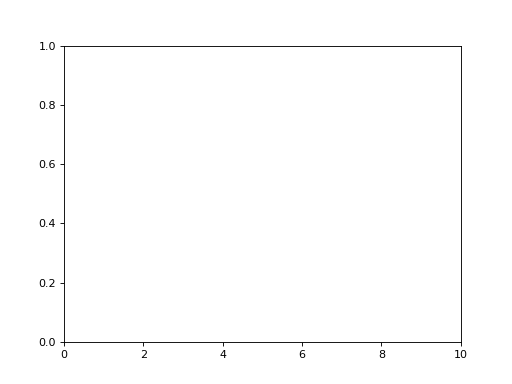

KeyError: 0.1

In [ ]:
plt.figure()
plt.xlim([0, 10])
plt.plot(np.array(tau_space), np.array(av_v[T_space[0]]), 'k', label='T = 60ms, calculated data')
#major_ticks = np.arange(0, 1.1, 0.1)
#minor_ticks = np.arange(0, 1.1, 0.05)
#plt.xticks(major_ticks)
#plt.xticks(minor_ticks, minor=True)
plt.grid(which='both')
plt.legend()

<IPython.core.display.Javascript object>


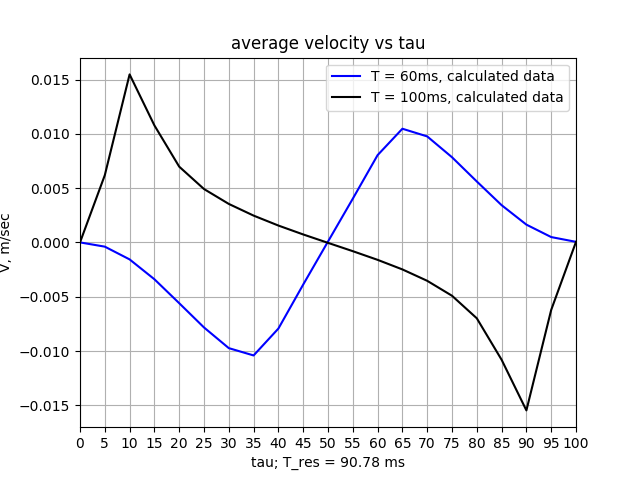

In [ ]:
np.savetxt('T60_calc.out', (np.array(tau_space)*100, np.array(av_v[T_space[0]])*toVel))
np.savetxt('T100_calc.out', (np.array(tau_space)*100, np.array(av_v[T_space[1]])*toVel))


#plt.figure(figsize=(9,6))
plt.plot(np.array(tau_space)*100, np.array(av_v[T_space[0]])*toVel, 'b', label='T = 60ms, calculated data')
#exp_x, exp_y = np.loadtxt('T60.out')
#plt.plot(exp_x, -exp_y, 'b--',label="T = 60ms, experiment data")


plt.plot(np.array(tau_space)*100, np.array(av_v[T_space[1]])*toVel, 'k', label='T = 100ms, calculated data')
#exp_x, exp_y = np.loadtxt('T100.out')
#plt.plot(exp_x, -exp_y, 'k--',label="T = 100ms, experiment data")

plt.xlim([0, 100])
plt.grid(True)
plt.legend()
plt.grid(True)
plt.title("average velocity vs tau")
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("tau; T_res = %.2f ms"% (2*np.pi/w*1E3))
plt.ylabel("V, m/sec")
plt.legend(loc='upper right')
#plt.savefig('V_tau_combined.jpg')

<IPython.core.display.Javascript object>


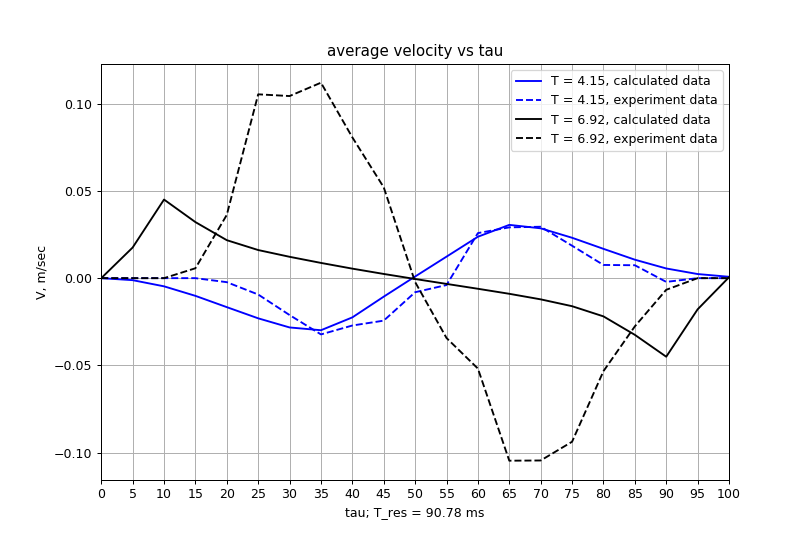

In [ ]:
#np.savetxt('T60_calc.out', (np.array(tau_space)*100, np.array(av_v[T_space[0]])*toVel))
#np.savetxt('T100_calc.out', (np.array(tau_space)*100, np.array(av_v[T_space[1]])*toVel))


plt.figure(figsize=(9,6))
plt.plot(np.array(tau_space)*100, np.array(av_v[T_space[0]]), 'b', label='T = 4.15, calculated data')
exp_x, exp_y = np.loadtxt('T60.out')
plt.plot(exp_x, -exp_y/toVel, 'b--',label="T = 4.15, experiment data")


plt.plot(np.array(tau_space)*100, np.array(av_v[T_space[1]]), 'k', label='T = 6.92, calculated data')
exp_x, exp_y = np.loadtxt('T100.out')
plt.plot(exp_x, -exp_y/toVel, 'k--',label="T = 6.92, experiment data")

plt.xlim([0, 100])
plt.grid(True)
plt.legend()
plt.grid(True)
plt.title("average velocity vs tau")
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("tau; T_res = %.2f ms"% (2*np.pi/w*1E3))
plt.ylabel("V, m/sec")
plt.legend(loc='upper right')
#plt.savefig('V_tau_combined_dl.jpg')

<IPython.core.display.Javascript object>


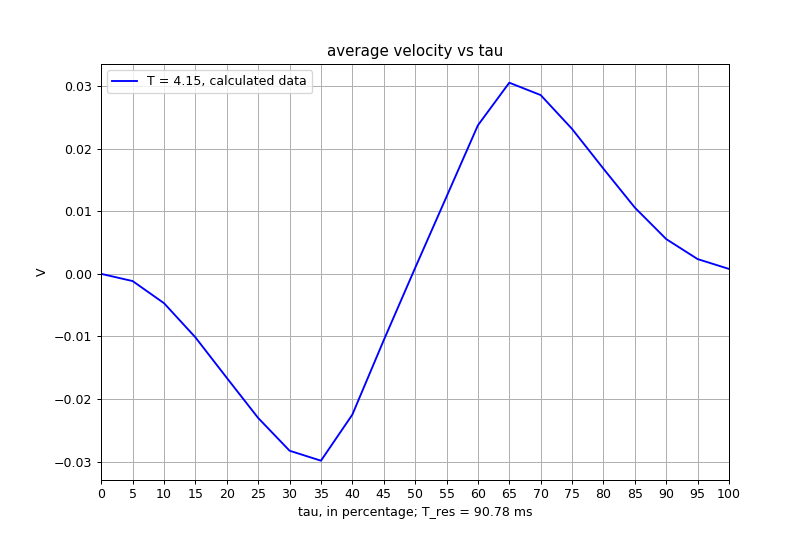

In [ ]:
#np.savetxt('T60_calc.out', (np.array(tau_space)*100, np.array(av_v[T_space[0]])*toVel))
#np.savetxt('T100_calc.out', (np.array(tau_space)*100, np.array(av_v[T_space[1]])*toVel))


plt.figure(figsize=(9,6))
plt.plot(np.array(tau_space)*100, np.array(av_v[T_space[0]]), 'b', label='T = 4.15, calculated data')
#exp_x, exp_y = np.loadtxt('T60.out')
#plt.plot(exp_x, -exp_y, 'b--',label="T = 60ms, experiment data")


#plt.plot(np.array(tau_space)*100, np.array(av_v[T_space[1]]), 'k', label='T = 6.92, calculated data')
#exp_x, exp_y = np.loadtxt('T100.out')
#plt.plot(exp_x, -exp_y, 'k--',label="T = 100ms, experiment data")

plt.xlim([0, 100])
plt.grid(True)
plt.legend()
plt.grid(True)
plt.title("average velocity vs tau")
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("tau, in percentage; T_res = %.2f ms"% (2*np.pi/w*1E3))
plt.ylabel("V")
plt.legend(loc='upper left')
plt.savefig('V_tau_calc_T_4.jpg')

# Integration of equations

In [ ]:
exp_x, exp_y = np.loadtxt('tau70.out')
plt.figure(figsize=(9,6))
plt.plot(T_space*toSec*1000, np.array(av_v[0.7])*toVel, 'b', label='calculated70')
plt.plot(exp_x, -exp_y, 'b--',label="experiment70")

exp_x, exp_y = np.loadtxt('tau30.out')
plt.plot(T_space*toSec*1000, np.array(av_v[0.3])*toVel, 'r', label='calculated30')
plt.plot(exp_x, -exp_y, 'r--',label="experiment30")
plt.xlim([0, 150])
plt.grid(True)
plt.legend()

In [ ]:
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 10.0
numpoints = 250

T = 6.0 #*
tau = 0.35

# Pack up the parameters and initial conditions:
p = [m1, m2, eps, T, tau]
x0 = [0, 0, 0, 0]

n_periods = 200
steps_in_period = 100
t = np.linspace(0, n_periods*T, steps_in_period*n_periods)

wsol = sp.integrate.odeint(f, x0, t, args=(p,)) #,
              #atol=abserr, rtol=relerr)
wsol = wsol.transpose()

In [ ]:
F_e(0.6, 1, 0.5)

3.1830988617143063e-06

In [ ]:
60*1E-3/toSec

4.1526693743136365

In [ ]:
#x, t = toDim(wsol, t, [w, L])
#wsol = x
#wsol[0][-1]/t[-1]

-0.061267746948876732

# Plot state vector

<IPython.core.display.Javascript object>


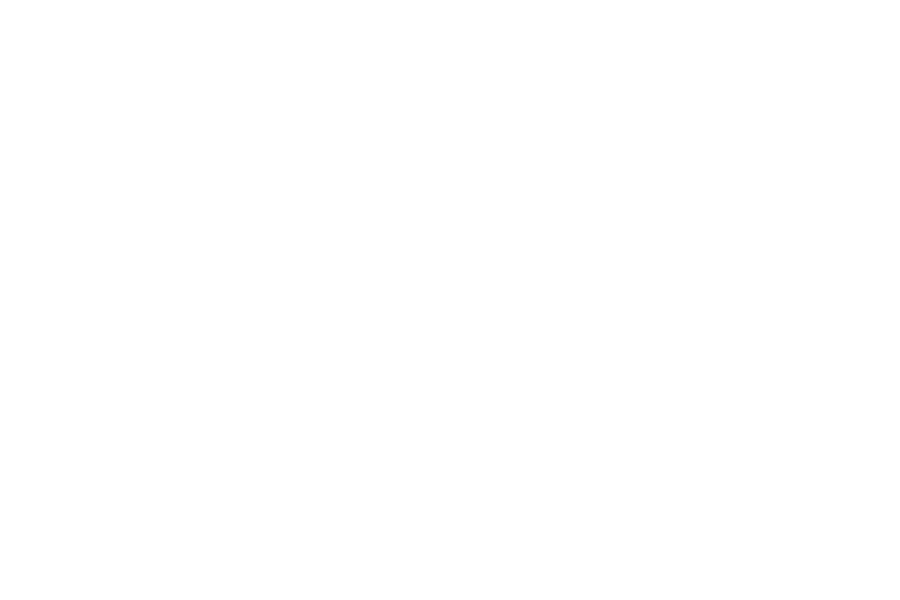

<IPython.core.display.Javascript object>


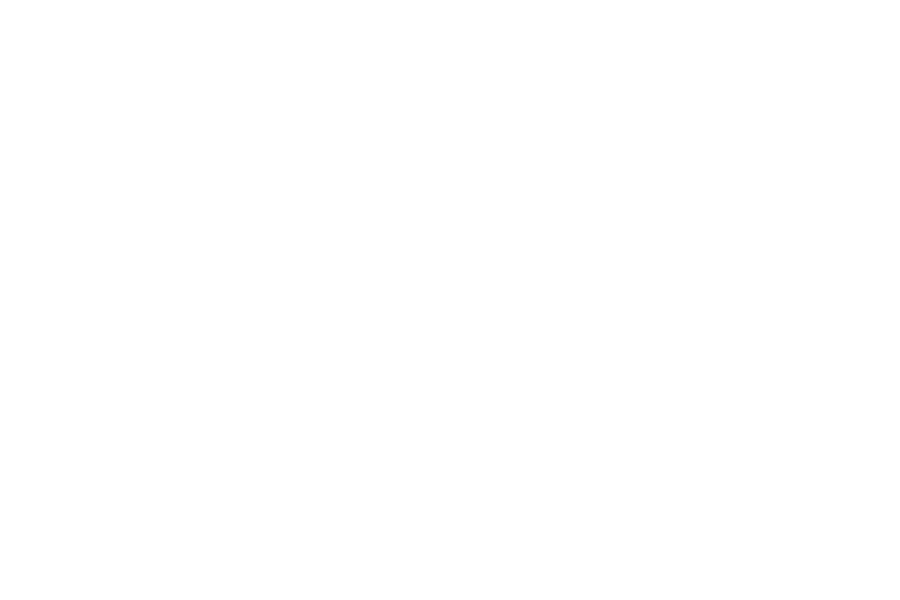

(616, 630)

In [ ]:


plt.figure(figsize=(9,6))
plt.plot(t, wsol[0])
plt.xlim([T*50, T*150])

plt.title('X')
plt.figure(figsize=(9,6))
#plt.plot(t, wsol[2])
plt.plot(t, wsol[1], '--')
#plt.plot(t, wsol[2])
plt.plot(t, wsol[3], '-.')

v_body = wsol[1] - m2*wsol[3]
plt.plot(t, v_body)
plt.title('v_body, ksi_dot, x_dot')
plt.xlim([616, 630])

(7.7, 0.1)


<IPython.core.display.Javascript object>


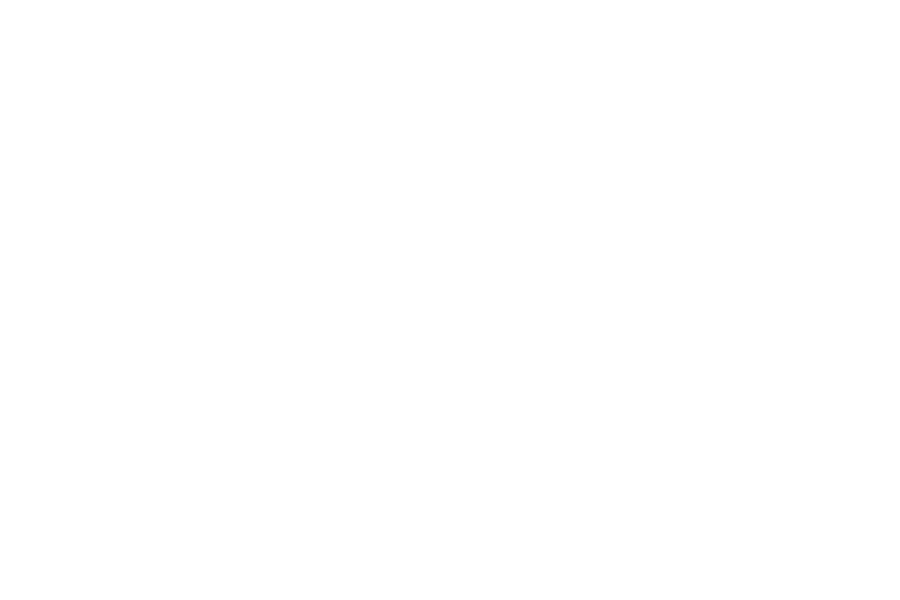

In [ ]:
t_ = np.linspace(0, 40, 1000)
#x = F_fr(t, eps)
x_ = F_e(t_, T, tau)
print(T, tau)
plt.figure(figsize=(9,6))
plt.plot(t_/T, x_)


In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def g(y, x):
    y0 = y[0]
    y1 = y[1]
    y2 = ((3*x+2)*y1 + (6*x-8)*y0)/(3*x-1)
    return y1, y2

# Initial conditions on y, y' at x=0
init = 2.0, 3.0
# First integrate from 0 to 2
x = np.linspace(0,2,100)
sol=odeint(g, init, x)
# Then integrate from 0 to -2
plt.plot(x, sol[:,0], color='b')
x = np.linspace(0,-2,100)
sol=odeint(g, init, x)
plt.plot(x, sol[:,0], color='b')

# The analytical answer in red dots
exact_x = np.linspace(-2,2,10)
exact_y = 2*np.exp(2*exact_x)-exact_x*np.exp(-exact_x)
plt.plot(exact_x,exact_y, 'o', color='r', label='exact')
plt.legend()

plt.show()

## All data analyze

In [ ]:
folders = ['1', '2', '3', '4']
settings_file = ['params']

In [ ]:
def getScale(folder):
    x, y = -1, -1
    try:
        with open(folder+'/params', 'r') as infile:
            for line in infile:
                if line.startswith('x'):
                    x = float(line.split()[1])
                if line.startswith('y'):
                    y = float(line.split()[1])
    except Exception as e:
        print(e)               
        
    if x == -1 or y == -1:
        raise NameError('Parameter in folder are wrong')
    return x, y

In [ ]:
#print(getScale(folder[1]))

In [ ]:
def calcAvVel(volts, timestamps):
    return sum(np.diff(volts))*(timestamps[-1] - timestamps[0])/100.

In [ ]:
#Tau is first two digits in filename
#Tw is rest digits, dimensionless period
#av_velocities = [] # array of arrays, 1 - data number, subarray has next form: tau, Tw, av_velocity
p = 0 # print flat

df = pd.DataFrame([],  columns=('tau', 'Tw', 'V', 'filename', 'folder'))
for folder in folders:
    for file_ in os.listdir(folder):
        if file_[-4:] == '.CSV':
            if p:
                print("Found data file: ")
                print(folder, file_)
            frame = pd.read_csv(folder+'/'+file_, header=0, sep=',')
            
            file_ = file_[:-4]
            Tau = int(file_[:2])
            Tw = int(file_[2:])
            if p:
                print('tau', Tau, 'Tw', Tw)
            timestamps = frame[frame.columns[0]].get_values()  #time in seconds
            volts = frame[frame.columns[1]].get_values()  #sensor data in volts
            v = calcAvVel(volts, timestamps)            
            if p:
                print(v)
            #av_velocities.append([Tau, Tw, v])
            df = df.append(pd.DataFrame([[Tau, Tw, v, file_, folder]],  columns=('tau', 'Tw', 'V', 'filename', 'folder')))
        elif file_ == 'params':
            if p:
                print("Found parameters: ")
                print(folder, file_)
            scale_time, scale_volts = getScale(folder)
                
if p:    
    print(df)


## Plots

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12,6)

## Plot: tau vs velocity

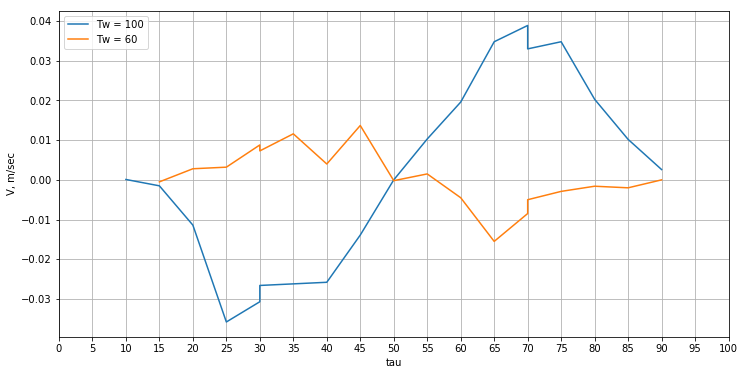

In [ ]:
TW = 100
subframe = df.loc[df['Tw'] == TW]
subframe = subframe.sort_values('tau')
x = np.array(subframe['tau'])
y = np.array(subframe['V'])
plt.plot(x, y, label="Tw = %d"%TW)


TW = 60
subframe = df.loc[df['Tw'] == TW]
subframe = subframe.sort_values('tau')
x = np.array(subframe['tau'])
y = np.array(subframe['V'])
plt.plot(x, y, label="Tw = %d"%TW)


plt.grid(True)
plt.xlim([0, 100])
plt.grid(True)
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("tau")
plt.ylabel("V, m/sec")
plt.legend(loc='upper left')
plt.savefig('V_tau_laser.jpg')

## Plot T vs velocity

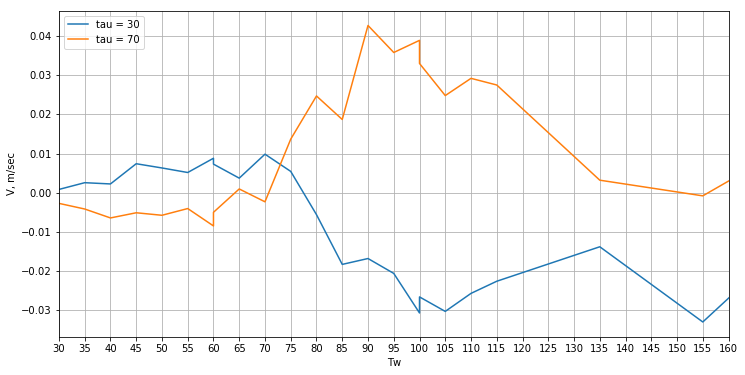

In [ ]:
tau = 30
subframe = df.loc[df['tau'] == tau]
subframe = subframe.sort_values('Tw')
x = np.array(subframe['Tw'])
y = np.array(subframe['V'])
plt.plot(x, y, label="tau = %d"%tau)


tau = 70
subframe = df.loc[df['tau'] == tau]
subframe = subframe.sort_values('Tw')
x = np.array(subframe['Tw'])
y = np.array(subframe['V'])
plt.plot(x, y, label="tau = %d"%tau)


xlim = [30, 160]
plt.grid(True)
plt.xlim(xlim)
plt.grid(True)
plt.xticks(np.arange(xlim[0], xlim[1]+1, 5))
plt.xlabel("Tw")
plt.ylabel("V, m/sec")
plt.legend(loc='upper left')
plt.savefig('V_T_laser.jpg')

## Recycle data from osciloscope

In [ ]:
def get_v(x, t):
    v = []
    x_prev = x[0]
    t_prev = t[0]
    for i in range(len(x)):
        if i == 0:
            continue
        dx = x[i] - x_prev
        dt = t[i] - t_prev
        x_prev = x[i]
        t_prev = t[i]
        
        v.append(dx/dt)
    return v
        
        

In [ ]:
def drawOsc(tau, Tw, folders):
    found = 0
    for folder in folders:
        for file_ in os.listdir(folder):
            if file_ == str(tau)+str(Tw)+'.CSV':
                frame = pd.read_csv(folder + '/' + file_, header=0, sep=',')
                found = 1
                print('found\n')

        #x_scale = 100E-3 #100 ms
        #y_scale = 200E-3 #200 mv ~ 0.2cm
    if found:
        x = frame[frame.columns[0]].get_values()  #time in seconds
        y = frame[frame.columns[1]].get_values()  #sensor data in volts
        plt.plot(x,y)
        #plt.axis([-0.5, 0.5, 0.98, 1.1])
        plt.xlabel("t; average_veloctity = %.2f m/s"% calcAvVel(x, y))
        
        v = get_v(y, x)
        print(len(v), len(x))
        #plt.plot(x[1:], v)
        #plt.xlim([-0.4, -0.3])
    

found

(9998, 9999)


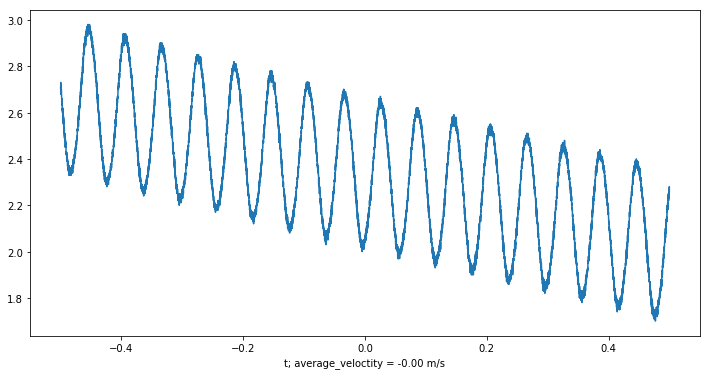

In [ ]:
drawOsc(60, 60, folders)